# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


Assume number of classes is $C$, input $X$, output $\hat{Y}$ and label $Y$ is $C$ elements vector, $i,j$ is integal number in $(0, C]$, our model will be:

$$ Z=W\cdot{X} \qquad a_i=\frac{e^{z_i}}{\sum_j^C{e^{z_j}}} \quad i\in\{1,2,\cdots,C\} \qquad \hat{Y}=A=(a_1,a_2,\cdots,a_C)$$

My understand is $a_i$ is the possibility of the image belonging to class $i$.

We use __cross entropy__ as loss function, which defined as:

$$ H(p,q)=E_p[-logq]=-\sum_i{p(i)\log{q(i)}} $$

Here, $p(i)$ is the possibility of an image belonging to class i in our label set. In most of ML cases, it will be one-hot value, which means only $p(y)$ is one, others will be zeros. $q(i)$ is our prediction, which equals $a_i$. Then we have:

$$ L=-\bigg[1\cdot{\log\Big(\frac{e^{z_y}}{\sum_j^C{e^{z_j}}}\Big)} + 0\cdot{\log\Big(\frac{e^{z_{i}}}{\sum_j^C{e^{z_j}}}\Big)} + \cdots\bigg] \\ = -\log\Big(\frac{e^{z_y}}{\sum_j^C{e^{z_j}}}\Big)=-z_y+\log{\sum_j^C{e^{z_j}}} $$

For $m$ training data, total loss will be:
$$ J=\frac{1}{m}\sum_t^m{L_t}+\frac{\lambda}{m}\Arrowvert W \Arrowvert^2_2 $$

In back-propagation, by applying chain rule, gradient will be:

$$ \frac{dL}{dZ}=-\frac{d}{dZ}e^{z_y}+\frac{d}{dZ}\big(\log{\sum_j^C{e^{z_j}}}\big)=\begin{cases}
    -1 + \frac{e^{z_i}}{\sum_j^C{e^{z_j}}}&\  i=y \\
    \frac{e^{z_i}}{\sum_j^C{e^{z_j}}}&\  i\neq y \end{cases}=\begin{cases}-1+a_i&\  i=y\\a_i&\  i\neq y\end{cases}$$

$$ \frac{dZ}{dW}=\frac{d}{dW}W\cdot X=X $$

$$\Rightarrow \frac{dL}{dW}=\frac{dL}{dZ}\cdot\frac{dZ}{dW}=\begin{cases}-X+a_i\cdot X&\ i=y\\a_i\cdot X&\  i\neq y\end{cases}$$
    

In [4]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.339957
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [5]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -2.541070 analytic: -2.541070, relative error: 2.226388e-08
numerical: -0.491710 analytic: -0.491710, relative error: 2.154074e-07
numerical: -1.836264 analytic: -1.836264, relative error: 4.367586e-09
numerical: 2.700503 analytic: 2.700503, relative error: 2.583154e-08
numerical: 0.992246 analytic: 0.992246, relative error: 2.457249e-09
numerical: 0.782354 analytic: 0.782354, relative error: 7.929631e-09
numerical: 0.758989 analytic: 0.758989, relative error: 2.110503e-08
numerical: 1.983561 analytic: 1.983561, relative error: 6.326317e-09
numerical: 4.238896 analytic: 4.238896, relative error: 2.110030e-08
numerical: -2.281986 analytic: -2.281986, relative error: 1.046475e-08
numerical: -1.155384 analytic: -1.155384, relative error: 5.871511e-08
numerical: -2.186090 analytic: -2.186090, relative error: 8.598762e-09
numerical: -1.189329 analytic: -1.189329, relative error: 3.748326e-08
numerical: 3.803063 analytic: 3.803063, relative error: 1.636151e-08
numerical: -2.283765

In [7]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.339957e+00 computed in 0.063802s
vectorized loss: 2.339957e+00 computed in 0.004014s
Loss difference: 0.000000
Gradient difference: 0.000000


In [31]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
num_validates = 50
num_iters = 2000

for i in range(num_validates):
    lr = np.random.uniform(learning_rates[0], learning_rates[1])
    reg = np.random.uniform(regularization_strengths[0], regularization_strengths[1])
    
    softmax = Softmax()
    
    loss = softmax.train(X_train, y_train, learning_rate = lr, reg = reg, num_iters=num_iters, verbose=False)
    
    y_train_pred = softmax.predict(X_train)
    train_accuracy = np.mean(y_train == y_train_pred)

    y_val_pred = softmax.predict(X_val)
    val_accuracy = np.mean(y_val == y_val_pred)
    
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_softmax = softmax

    results[(lr, reg)] = (train_accuracy, val_accuracy)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 2.463603e-07 reg 4.930533e+04 train accuracy: 0.306306 val accuracy: 0.328000
lr 3.286515e-07 reg 3.350739e+04 train accuracy: 0.321224 val accuracy: 0.326000
lr 3.041362e-07 reg 4.639691e+04 train accuracy: 0.311653 val accuracy: 0.314000
lr 2.991952e-07 reg 4.159265e+04 train accuracy: 0.305878 val accuracy: 0.319000
lr 4.278987e-07 reg 4.669984e+04 train accuracy: 0.314653 val accuracy: 0.333000
lr 2.906603e-07 reg 3.131432e+04 train accuracy: 0.332102 val accuracy: 0.331000
lr 2.334281e-07 reg 3.441307e+04 train accuracy: 0.308612 val accuracy: 0.322000
lr 2.802770e-07 reg 3.613315e+04 train accuracy: 0.313633 val accuracy: 0.337000
lr 1.632774e-07 reg 4.032051e+04 train accuracy: 0.310735 val accuracy: 0.329000
lr 1.615345e-07 reg 3.154041e+04 train accuracy: 0.329796 val accuracy: 0.346000
lr 2.936593e-07 reg 4.600725e+04 train accuracy: 0.319429 val accuracy: 0.340000
lr 2.915159e-07 reg 4.911067e+04 train accuracy: 0.295633 val accuracy: 0.314000
lr 2.421298e-07 reg 3.937995

In [32]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.349000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*:

*Your explanation*:

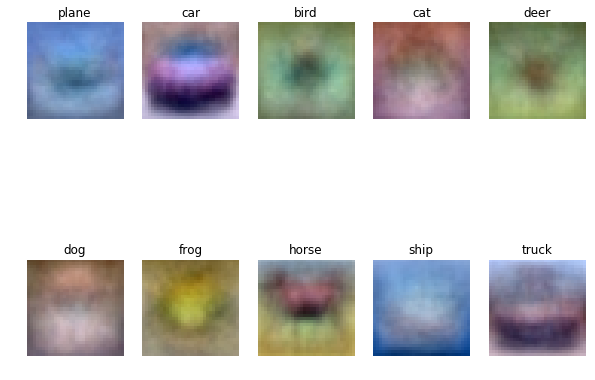

In [33]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])